## Importing libraries

In [133]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
import random
import os
import matplotlib.pyplot as plt
from PIL import Image  # Import PIL to resize images
import shutil

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split

import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.metrics import classification_report, confusion_matrix

import seaborn as sns
from torchvision.transforms import RandomHorizontalFlip, RandomRotation, ColorJitter

from cnn import SimpleCNN, MobileNet, MobileNet, train_model

#### Set the seed for reproducibility


In [134]:
seed = 501

torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

g = torch.Generator()
g.manual_seed(seed)



#### Clear the contents of the working directory to save our data after splitting. 

In [135]:
# Set the path to the Kaggle working directory
working_dir = r'..\data\working'

# Delete all files and subdirectories in the working directory
for item in os.listdir(working_dir):
    item_path = os.path.join(working_dir, item)
    if os.path.isfile(item_path):
        os.remove(item_path)
    elif os.path.isdir(item_path):
        shutil.rmtree(item_path)

# Confirm that the directory is empty
print("Working directory has been cleared.")


Working directory has been cleared.


## Defining Tranformation and Augmentation function

Transformation and augmentation are techniques commonly used in machine learning and computer vision, especially in the context of training deep learning models, including neural networks. These techniques are primarily applied to manipulate and enhance the training data to improve the model's performance, generalization, and robustness.

Image Transformation: In computer vision, image transformation refers to operations that alter the appearance of an image without changing its semantic content. Common image transformations include resizing, cropping, rotation, flipping, and color adjustments.

Data Augmentation: Data augmentation is a technique used to artificially increase the diversity of the training dataset by applying various transformations to the existing data. In computer vision, this often involves generating new training samples by randomly applying operations like rotation, translation, scaling, shearing, flipping, and introducing random noise to the images. Augmentation helps the model generalize better to unseen data and reduces overfitting.

The primary goal of both transformation and augmentation is to make the model more resilient to variations and noise in the input data, ultimately improving its ability to make accurate predictions on real-world, unseen data. These techniques are particularly important in deep learning, where models have a large number of parameters and can easily overfit to the training data if not exposed to diverse examples.

We will also be applying extra augmentation to our minority classes in the train dataset to balance out training dataset so our model can generalize better.

In [136]:

# Define the minority classes in your dataset
class_names = ['malignant', 'normal','benign']
minority_classes = ['malignant', 'normal']

# Define custom data transformations for minority classes
minority_class_transforms = transforms.Compose([
    RandomHorizontalFlip(p=0.9),  # Apply with 90% probability
    RandomRotation(15, expand=False, center=None),
    ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
])

# Define data transformations for train, validation, and test sets
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        # Apply custom augmentations to minority classes
        transforms.RandomApply([minority_class_transforms], p=0.5) if any(cls in minority_classes for cls in class_names) else transforms.RandomApply([], p=0.0),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

### Data Split and create folders- excludes mask files

In [137]:
# Set the path to your input folder
data_dir = r'..\data\original'

# Define the paths for the train, validation, and test directories
train_dir = r'..\data\working\train'
val_dir = r'..\data\working\validation'
test_dir = r'..\data\working\test'

# Create a list to store file paths and labels
file_paths = []
labels = []

# Loop through the subdirectories (benign, malignant, normal)
for label in os.listdir(data_dir):
    label_dir = os.path.join(data_dir, label)
    if os.path.isdir(label_dir):
        for image_file in os.listdir(label_dir):
            if image_file.endswith('.png') and not (image_file.endswith('_mask.png') or 
                                                     image_file.endswith('_mask_1.png') or
                                                     image_file.endswith('_mask_2.png')):
                image_path = os.path.join(label_dir, image_file)
                labels.append(label)
                file_paths.append(image_path)

# Create a DataFrame to store the file paths and labels
data = pd.DataFrame({'Image_Path': file_paths, 'Label': labels})

# Split the dataset into train, validation, and test sets
train_data, test_data = train_test_split(data, test_size=0.15, random_state=seed, stratify=data['Label'])
train_data, val_data = train_test_split(train_data, test_size=0.15, random_state=seed, stratify=train_data['Label'])



# Create the train, validation, and test directories and subdirectories
for label in labels:
    os.makedirs(os.path.join(train_dir, label), exist_ok=True)
    os.makedirs(os.path.join(test_dir, label), exist_ok=True)
    os.makedirs(os.path.join(val_dir, label), exist_ok=True)

# List of tuples containing data and corresponding directories
data_dirs = [(train_data, train_dir), (test_data, test_dir), (val_data, val_dir)]

# Copy the images to the respective directories
for data, directory in data_dirs:
    for _, row in data.iterrows():
        image_path = row['Image_Path']
        label = row['Label']
        shutil.copy(image_path, os.path.join(directory, label))




Get the label counts after split - excludes mask files

In [138]:
dirs = [train_dir, test_dir, val_dir]
subdirs = ['benign', 'malignant', 'normal']

dir_names = ['train', 'test', 'validation']

for i, dir in enumerate(dirs):
    file_counts = {}
    for subdirectory in subdirs:
        subdirectory_path = os.path.join(dir, subdirectory)
        if os.path.exists(subdirectory_path):
            file_count = len(os.listdir(subdirectory_path))
            file_counts[subdirectory] = file_count

    for category, count in file_counts.items():
        print(f"{dir_names[i]} {category}: {count}")



train benign: 315
train malignant: 152
train normal: 96
test benign: 66
test malignant: 31
test normal: 20
validation benign: 56
validation malignant: 27
validation normal: 17


Apply transfromation and augmentation to the datasets. Augmentation is only applied to the training data with extra focus on minority classes to balance the dataset. Calling the function that was defined earlier in the notebook.

In [139]:
data_dir=r'..\data\working'

# Create datasets for train, validation, and test
image_datasets = {
    x: ImageFolder(
        root=os.path.join(data_dir, x),
        transform=data_transforms[x]
    )
    for x in ['train', 'validation', 'test']
}

# Specify batch size for dataloaders
batch_size = 8  # You can adjust this based on your hardware and preferences

# Create dataloaders for train, validation, and test
dataloaders = {x: DataLoader(
                image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=0, generator=g)
               for x in ['train', 'validation', 'test']}

# Calculate dataset sizes
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation', 'test']}

# Get class labels
class_names = image_datasets['train'].classes

# Print dataset sizes and class labels
print("Dataset Sizes:", dataset_sizes)
print("Class Labels:", class_names)

Dataset Sizes: {'train': 563, 'validation': 100, 'test': 117}
Class Labels: ['benign', 'malignant', 'normal']


# Training the models

Point to GPU if exists

In [140]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Initialize the models

In [141]:
# Simple CNN
simple_cnn = SimpleCNN().to(device)
optimizer_cnn = optim.Adam(simple_cnn.parameters(), lr=0.001)
scheduler_cnn = lr_scheduler.StepLR(optimizer_cnn, step_size=7, gamma=0.1)

# MobileNet
mobilenet = MobileNet().to(device)
optimizer_mobilenet = optim.Adam(mobilenet.parameters(), lr=0.001)
scheduler_mobilenet = lr_scheduler.StepLR(optimizer_mobilenet, step_size=7, gamma=0.1)

# ResNet
resnet101 = models.resnet101(weights=True)
for param in resnet101.parameters():
    param.requires_grad = True
in_features = resnet101.fc.in_features
resnet101.fc = nn.Linear(in_features, len(class_names))
resnet101 = resnet101.to(device)
optimizer_resnet = optim.Adam(resnet101.parameters(), lr=0.00005)
scheduler_resnet = lr_scheduler.StepLR(optimizer_resnet, step_size=7, gamma=0.1)


loss_function = nn.CrossEntropyLoss()

C:\Users\Erik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Train and validate

In [142]:

print("Training Simple CNN Model \n")
cnn_model, cnn_metrics = train_model(
    simple_cnn, loss_function, optimizer_cnn, scheduler_cnn,
    dataloaders, dataset_sizes, class_names, device, num_epochs=20, patience=2, min_epochs=5
)


Training Simple CNN Model 

Epoch 0/19
----------
train Loss: 1.1728 Acc: 0.5329
validation Loss: 0.9614 Acc: 0.5600

Epoch 1/19
----------
train Loss: 0.9291 Acc: 0.5950
validation Loss: 1.0278 Acc: 0.6000

Epoch 2/19
----------
train Loss: 0.8106 Acc: 0.6412
validation Loss: 0.9901 Acc: 0.5700

Epoch 3/19
----------
train Loss: 0.7363 Acc: 0.6856
validation Loss: 1.0331 Acc: 0.6200

Epoch 4/19
----------
train Loss: 0.7360 Acc: 0.7123
validation Loss: 0.8134 Acc: 0.6500

Epoch 5/19
----------
train Loss: 0.5950 Acc: 0.7780
validation Loss: 0.7599 Acc: 0.7200

Epoch 6/19
----------
train Loss: 0.5960 Acc: 0.7691
validation Loss: 1.0782 Acc: 0.6600

Epoch 7/19
----------
train Loss: 0.5134 Acc: 0.7886
validation Loss: 0.8919 Acc: 0.6800
Early stopping after 8 epochs
Training complete in 1m 15s
Best val Loss: 0.7599
              precision    recall  f1-score   support

      benign       0.74      0.80      0.77        56
   malignant       0.71      0.63      0.67        27
      norm

In [143]:
print("Training MobileNet Model \n")
mobilenet_model, mobilenet_metrics = train_model(
    mobilenet, loss_function, optimizer_mobilenet, scheduler_mobilenet,
    dataloaders, dataset_sizes, class_names, device, num_epochs=20, patience=2, min_epochs=5
) 

Training MobileNet Model 

Epoch 0/19
----------
train Loss: 33.1868 Acc: 0.4867
validation Loss: 23.1683 Acc: 0.3300

Epoch 1/19
----------
train Loss: 7.4619 Acc: 0.5417
validation Loss: 3.5832 Acc: 0.4700

Epoch 2/19
----------
train Loss: 1.9055 Acc: 0.5737
validation Loss: 0.9959 Acc: 0.5200

Epoch 3/19
----------
train Loss: 0.8923 Acc: 0.6039
validation Loss: 0.9716 Acc: 0.5600

Epoch 4/19
----------
train Loss: 0.7761 Acc: 0.6501
validation Loss: 0.9050 Acc: 0.6100

Epoch 5/19
----------
train Loss: 0.8335 Acc: 0.6430
validation Loss: 0.9150 Acc: 0.6200

Epoch 6/19
----------
train Loss: 0.7727 Acc: 0.6519
validation Loss: 0.9014 Acc: 0.6000

Epoch 7/19
----------
train Loss: 0.7406 Acc: 0.6927
validation Loss: 0.9114 Acc: 0.5800

Epoch 8/19
----------
train Loss: 0.6916 Acc: 0.7211
validation Loss: 0.9061 Acc: 0.6200
Early stopping after 9 epochs
Training complete in 11m 58s
Best val Loss: 0.9014
              precision    recall  f1-score   support

      benign       0.60   

C:\Users\Erik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Erik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Erik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.

In [144]:
print("\nTraining ResNet Model \n")
resnet_model, resnet_metrics = train_model(
    resnet101, loss_function, optimizer_resnet, scheduler_resnet,
    dataloaders, dataset_sizes, class_names, device, num_epochs=20, patience=2, min_epochs=5
)


Training ResNet Model 

Epoch 0/19
----------
train Loss: 0.7420 Acc: 0.6750
validation Loss: 0.6188 Acc: 0.7400

Epoch 1/19
----------
train Loss: 0.4264 Acc: 0.8401
validation Loss: 0.5825 Acc: 0.7700

Epoch 2/19
----------
train Loss: 0.3372 Acc: 0.8828
validation Loss: 0.5780 Acc: 0.8100

Epoch 3/19
----------
train Loss: 0.2806 Acc: 0.9059
validation Loss: 0.6614 Acc: 0.8100

Epoch 4/19
----------
train Loss: 0.2252 Acc: 0.9236
validation Loss: 0.5283 Acc: 0.8300

Epoch 5/19
----------
train Loss: 0.2605 Acc: 0.9076
validation Loss: 0.5593 Acc: 0.8200

Epoch 6/19
----------
train Loss: 0.2073 Acc: 0.9343
validation Loss: 0.5990 Acc: 0.8400
Early stopping after 7 epochs
Training complete in 1m 37s
Best val Loss: 0.5283
              precision    recall  f1-score   support

      benign       0.83      0.93      0.87        56
   malignant       0.79      0.70      0.75        27
      normal       0.92      0.71      0.80        17

    accuracy                           0.83     

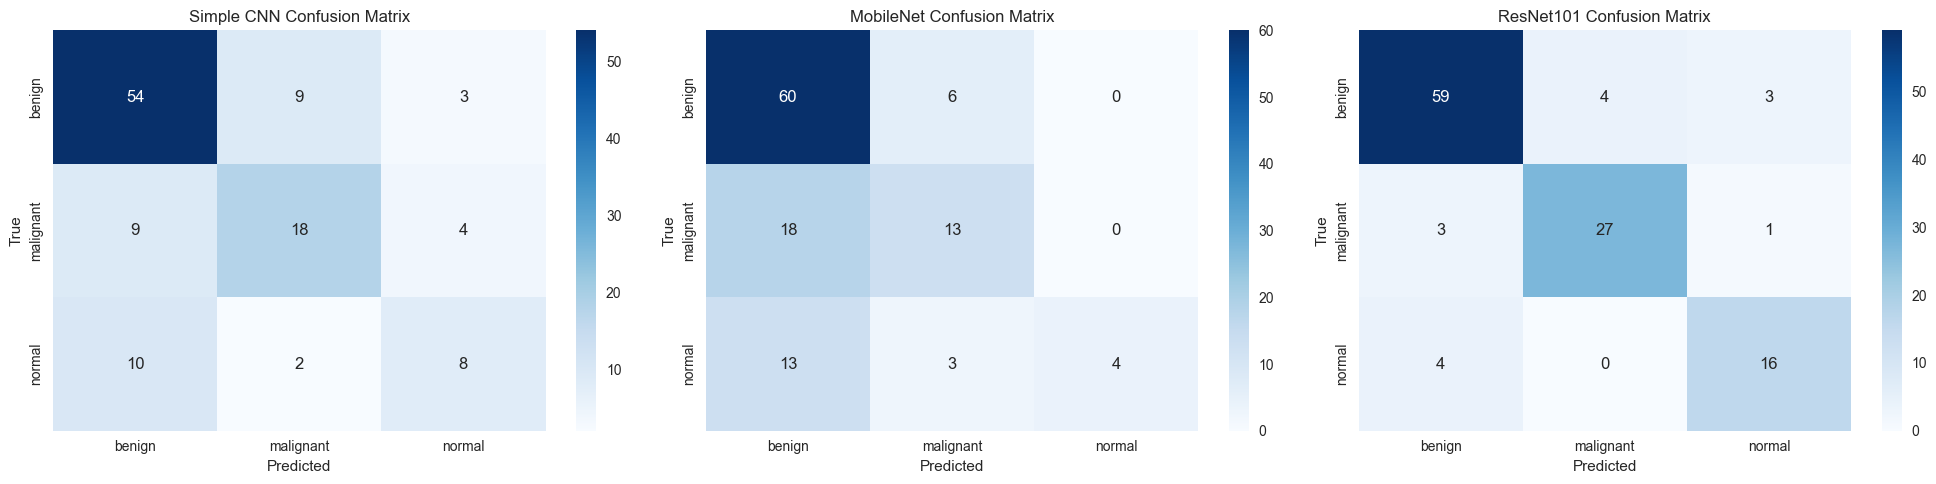


Simple CNN Classification Report:
              precision    recall  f1-score   support

      benign       0.74      0.82      0.78        66
   malignant       0.62      0.58      0.60        31
      normal       0.53      0.40      0.46        20

    accuracy                           0.68       117
   macro avg       0.63      0.60      0.61       117
weighted avg       0.67      0.68      0.68       117


MobileNet Classification Report:
              precision    recall  f1-score   support

      benign       0.66      0.91      0.76        66
   malignant       0.59      0.42      0.49        31
      normal       1.00      0.20      0.33        20

    accuracy                           0.66       117
   macro avg       0.75      0.51      0.53       117
weighted avg       0.70      0.66      0.62       117


ResNet101 Classification Report:
              precision    recall  f1-score   support

      benign       0.89      0.89      0.89        66
   malignant       0.87   

In [147]:
# Get predictions for test set
def get_predictions(model, test_loader):
    y_true = []
    y_pred = []
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    return y_true, y_pred

test_loader = DataLoader(image_datasets['test'], batch_size=32, shuffle=False)
y_true_cnn, y_pred_cnn = get_predictions(cnn_model, test_loader)
y_true_resnet, y_pred_resnet = get_predictions(resnet_model, test_loader)
y_true_mobilenet, y_pred_mobilenet = get_predictions(mobilenet_model, test_loader)

# Plot confusion matrices side by side
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

# CNN confusion matrix
conf_matrix_cnn = confusion_matrix(y_true_cnn, y_pred_cnn)
sns.heatmap(conf_matrix_cnn, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=class_names, yticklabels=class_names)
ax1.set_title('Simple CNN Confusion Matrix')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('True')

# MobileNet confusion matrix
conf_matrix_mobilenet = confusion_matrix(y_true_mobilenet, y_pred_mobilenet)
sns.heatmap(conf_matrix_mobilenet, annot=True, fmt='d', cmap='Blues', ax=ax2,
            xticklabels=class_names, yticklabels=class_names)
ax2.set_title('MobileNet Confusion Matrix')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('True')

# ResNet confusion matrix
conf_matrix_resnet = confusion_matrix(y_true_resnet, y_pred_resnet)
sns.heatmap(conf_matrix_resnet, annot=True, fmt='d', cmap='Blues', ax=ax3,
            xticklabels=class_names, yticklabels=class_names)
ax3.set_title('ResNet101 Confusion Matrix')
ax3.set_xlabel('Predicted')
ax3.set_ylabel('True')

plt.tight_layout()
plt.savefig(f'../figs/confusion_matrices.pdf')
plt.show()

# Print classification reports
print("\nSimple CNN Classification Report:")
print(classification_report(y_true_cnn, y_pred_cnn, target_names=class_names))

print("\nMobileNet Classification Report:")
print(classification_report(y_true_mobilenet, y_pred_mobilenet, target_names=class_names))

print("\nResNet101 Classification Report:")
print(classification_report(y_true_resnet, y_pred_resnet, target_names=class_names))



C:\Users\Erik\AppData\Local\Temp\ipykernel_73588\2583065048.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


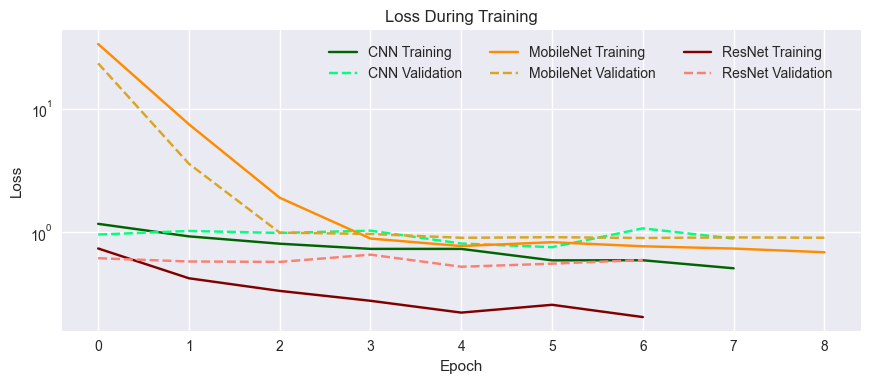

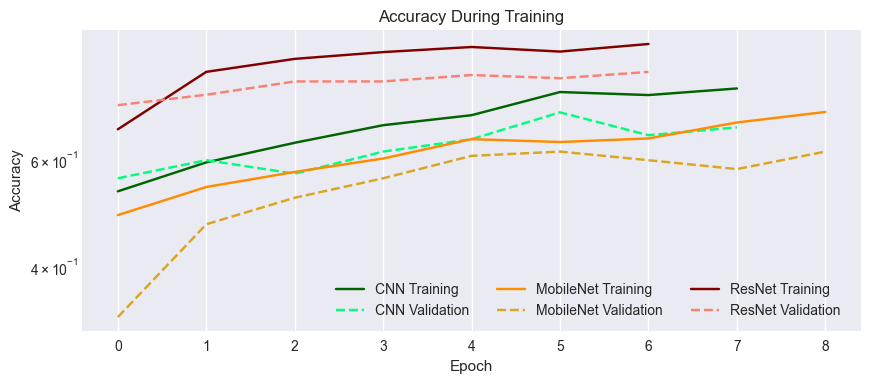

In [146]:
# Set seaborn style theme
sns.set_theme(style="darkgrid")
plt.style.use('seaborn')

# Plot training metrics
plt.figure(figsize=(9, 4))

# Loss plot
plt.semilogy(cnn_metrics['train_loss'], label='CNN Training', color='darkgreen')
plt.semilogy(cnn_metrics['val_loss'], label='CNN Validation', color='springgreen', linestyle='--') 
plt.semilogy(mobilenet_metrics['train_loss'], label='MobileNet Training', color='darkorange')
plt.semilogy(mobilenet_metrics['val_loss'], label='MobileNet Validation', color='goldenrod', linestyle='--')
plt.semilogy(resnet_metrics['train_loss'], label='ResNet Training', color='maroon')
plt.semilogy(resnet_metrics['val_loss'], label='ResNet Validation', color='salmon', linestyle='--')
plt.title('Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(ncol=3, bbox_to_anchor=(0.65, 0.99), loc='upper center')

plt.tight_layout()
plt.savefig(f'../figs/cnn_loss.pdf')


plt.figure(figsize=(9, 4))

plt.semilogy(cnn_metrics['train_acc'], label='CNN Training', color='darkgreen')
plt.semilogy(cnn_metrics['val_acc'], label='CNN Validation', color='springgreen', linestyle='--')
plt.semilogy(mobilenet_metrics['train_acc'], label='MobileNet Training', color='darkorange')
plt.semilogy(mobilenet_metrics['val_acc'], label='MobileNet Validation', color='goldenrod', linestyle='--')
plt.semilogy(resnet_metrics['train_acc'], label='ResNet Training', color='maroon') 
plt.semilogy(resnet_metrics['val_acc'], label='ResNet Validation', color='salmon', linestyle='--')
plt.title('Accuracy During Training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=3, bbox_to_anchor=(0.65, 0), loc='lower center')


plt.tight_layout()
plt.savefig(f'../figs/cnn_accuracy.pdf')
